# Qubit rotation

This example shows the basic operation of machine learning framework with a quantum device. A qubit is initilized with a arbitary Rx and Ry rotation and the target state is pure |1> state. After several steps of the iteration. The rotation angle of Rx and Ry will converge to 0 and pi. 

### About this example
The example contains the model compiled with three different configurations of backends and interfaces -- JAX backend, JAX backend with pytorch interface and pytorch backend.
The example also shows how to use state vector propagation mode and tensor network contraction mode. And two methods for obtaining gradient -- back propagation and parameter shift.

# Initialization

In [1]:
import tedq as qai

# Define the quantum model

### Define the circuit with TeD-Q framework
#### (Remember, if you have multiple measurements, all the measurement results should has the same shape!)

In [2]:
# Define quantum circuit
import numpy as np
matrix = np.array([i for i in range(16)])
def circuitDef(params):
    qai.RX(params[0], qubits=[0])
    qai.RY(params[1], qubits=[0])
    qai.Unitary(matrix, qubits=[0,2])
    return qai.expval(qai.PauliZ(qubits=[0]))

number_of_qubits = 3
parameter_shapes = [(2,)]

# Quantum circuit construction
circuit = qai.Circuit(circuitDef, number_of_qubits, parameter_shapes = parameter_shapes)

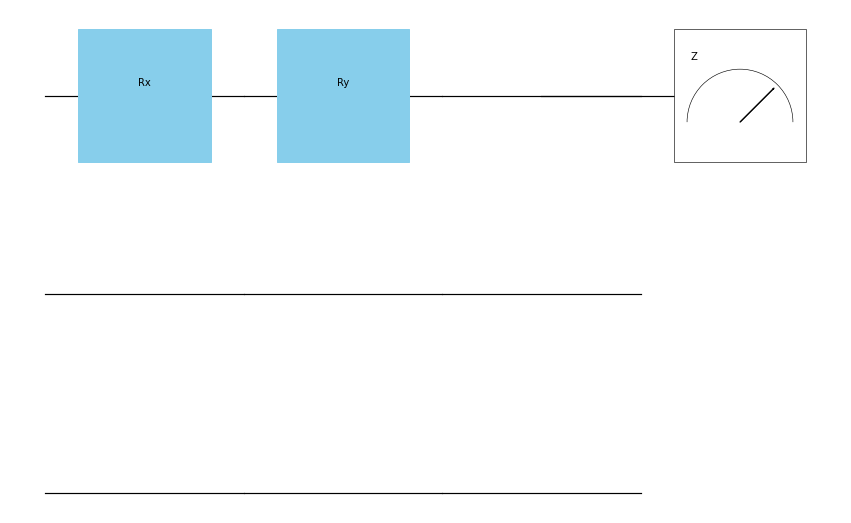

In [3]:
# visualization of the quantum circuit
drawer = qai.matplotlib_drawer(circuit)
drawer.draw_circuit()

# Circuit compiled with JAX backend
Gradient will obtain from backpropagation by default

### state vector propagation mode

In [4]:
my_compilecircuit = circuit.compilecircuit(backend="jax")

log10(flops) of this quantum circuit:   2.017033339299198


### tensor network contraction mode

#### Use CoTenGra

In [5]:
# slicing_opts = {'target_size': 2**28}
# hyper_opt = {'methods':['kahypar'], 'max_time':120, 'max_repeats':12, 'progbar':True, 'minimize':'flops', 'parallel':True, 'slicing_opts':slicing_opts}
# import cotengra as ctg
# my_compilecircuit = circuit.compilecircuit(backend="jax", use_cotengra=ctg, hyper_opt = hyper_opt)

#### Use JDtensorPath (Suggested)
1. 'target_num_slices' is useful if you want to do the contraction in parallel, it will devide the tensor network into pieces and then calculat them in parallel
2. 'math_repeats' means how many times are going to run JDtensorPath to find a best contraction path
3. 'search_parallel' means to run the JDtensorPath in parallel, True means to use all the CPUs, integer number means to use that number of CPUs


In [6]:
from jdtensorpath import JDOptTN as jdopttn
slicing_opts = {'target_size':2**28, 'repeats':500, 'target_num_slices':None, 'contract_parallel':False}
hyper_opt = {'methods':['kahypar'], 'max_time':120, 'max_repeats':12, 'search_parallel':True, 'slicing_opts':slicing_opts}
my_compilecircuit = circuit.compilecircuit(backend="jax", use_jdopttn=jdopttn, hyper_opt = hyper_opt, tn_simplify = False)

log10(flops) of this quantum circuit:   2.017033339299198


2022-06-21 16:17:36,120	INFO services.py:1263 -- View the Ray dashboard at http://127.0.0.1:8265


log2(size) before slicing:  4.000000000009017
log10(flops) before removed:    2.3404441148403166


### Define cost function

In [7]:
def cost(*params):
    return my_compilecircuit(*params)[0]

In [8]:
new_params = (0.011, 0.012)
cost(*new_params)

DeviceArray(-11.476284, dtype=float32)

### Define optimizer
TeD-Q built-in optimizer

In [9]:
Optimizer = qai.GradientDescentOptimizer(cost, [0, 1], 0.4, interface="jax")

### Training

In [10]:
%%time
new_params = (0.011, 0.012)
for i in range(100):
    new_params = Optimizer.step(*new_params)
    if (i + 1) % 5 == 0:
        print("Cost after step {:5d}: {: .7f}".format(i + 1, cost(*new_params)))
        print("Parameters after step {:5d}: {}".format(i + 1, new_params))
print(new_params)
print(cost(*new_params))

Cost after step     5:  8.8062057
Parameters after step     5: (DeviceArray(3.09056, dtype=float32), DeviceArray(-15.003746, dtype=float32))
Cost after step    10: -60.8229141
Parameters after step    10: (DeviceArray(2.1576805, dtype=float32), DeviceArray(-6.319555, dtype=float32))
Cost after step    15: -15.4167442
Parameters after step    15: (DeviceArray(35.55224, dtype=float32), DeviceArray(10.634235, dtype=float32))
Cost after step    20: -76.1620636
Parameters after step    20: (DeviceArray(59.48906, dtype=float32), DeviceArray(8.148323, dtype=float32))
Cost after step    25: -33.8629150
Parameters after step    25: (DeviceArray(101.236176, dtype=float32), DeviceArray(12.184772, dtype=float32))
Cost after step    30: -69.7446060
Parameters after step    30: (DeviceArray(84.78963, dtype=float32), DeviceArray(-16.829973, dtype=float32))
Cost after step    35: -48.6566505
Parameters after step    35: (DeviceArray(84.15408, dtype=float32), DeviceArray(-66.71156, dtype=float32))
Cost

### Trained circuit

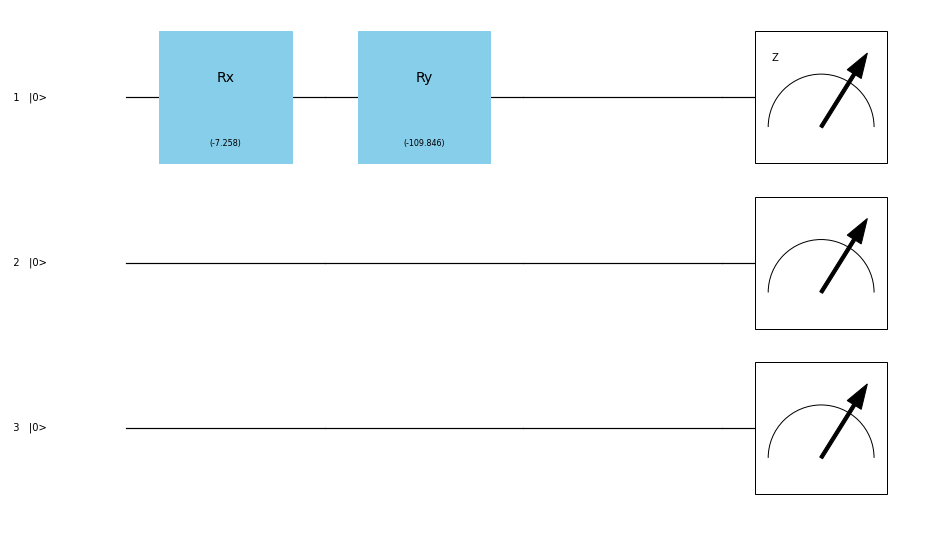

In [12]:
trainedCircuit = qai.Circuit(circuitDef, 3, new_params)
drawer = qai.matplotlib_drawer(trainedCircuit)
drawer.full_draw()

# Circuit compiled with JAX backend and pytorch interface
Gradient will obtain from backpropagation by default

### state vector propagation mode

In [ ]:
# my_compilecircuit = circuit.compilecircuit(backend="jax", interface="pytorch")

In [ ]:
from jax import numpy as jnp
a = jnp.array([[1,2],[2,4]])

In [ ]:
a.shape

### tensor network contraction mode

#### by using cotengra

In [ ]:
slicing_opts = {'target_size': 2**28}
hyper_opt = {'methods':['kahypar'], 'max_time':120, 'max_repeats':12, 'progbar':True, 'minimize':'flops', 'parallel':True, 'slicing_opts':slicing_opts}
import cotengra as ctg
my_compilecircuit = circuit.compilecircuit(backend="jax", use_cotengra=ctg, hyper_opt = hyper_opt, interface="pytorch")

#### Use JDtensorPath (Suggested)
1. 'target_num_slices' is useful if you want to do the contraction in parallel, it will devide the tensor network into pieces and then calculat them in parallel
2. 'math_repeats' means how many times are going to run JDtensorPath to find a best contraction path
3. 'search_parallel' means to run the JDtensorPath in parallel, True means to use all the CPUs, integer number means to use that number of CPUs


In [ ]:
# from jdtensorpath import JDOptTN as jdopttn
# slicing_opts = {'target_size':2**28, 'repeats':500, 'target_num_slices':None, 'contract_parallel':False}
# hyper_opt = {'methods':['kahypar'], 'max_time':120, 'max_repeats':12, 'search_parallel':True, 'slicing_opts':slicing_opts}
# my_compilecircuit = circuit.compilecircuit(backend="jax", use_jdopttn=jdopttn, hyper_opt = hyper_opt, tn_simplify = False, interface="pytorch")

### Define cost function and optimizer

### Define cost function and optimizer

In [ ]:
def cost(*params):
    return my_compilecircuit(*params)

In [ ]:
# using TeD-Q built-in optimizer
Optimizer = qai.GradientDescentOptimizer(cost, [0, 1], 0.4, interface="pytorch")

### Training

In [ ]:
import torch
a = torch.tensor([0.011], requires_grad= True)
b = torch.tensor([0.012], requires_grad= True)
my_params = (a, b)

In [ ]:
%%time
new_params = my_params
for i in range(100):
    new_params = Optimizer.step(*new_params)
    if (i + 1) % 5 == 0:
        print("Cost after step {:5d}: {: .7f}".format(i + 1, cost(*new_params)))
        print("Parameters after step {:5d}: {}".format(i + 1, new_params))
print(new_params)
print(cost(*new_params))

### Trained circuit

In [ ]:
trainedCircuit = qai.Circuit(circuitDef, 1, new_params)
drawer = qai.matplotlib_drawer(trainedCircuit)
drawer.full_draw()

# Circuit compiled with pytorch backend

Gradient will obtain from backpropagation by default

### state vector propagation mode

In [ ]:
# my_compilecircuit = circuit.compilecircuit(backend="pytorch")

### tensor network contraction mode

#### Use CoTenGra

In [ ]:
# slicing_opts = {'target_size': 2**28}
# hyper_opt = {'methods':['kahypar'], 'max_time':120, 'max_repeats':12, 'progbar':True, 'minimize':'flops', 'parallel':True, 'slicing_opts':slicing_opts}
# import cotengra as ctg
# my_compilecircuit = circuit.compilecircuit(backend="pytorch", use_cotengra=ctg, hyper_opt = hyper_opt)

#### Use JDtensorPath (Suggested)
1. 'target_num_slices' is useful if you want to do the contraction in parallel, it will devide the tensor network into pieces and then calculat them in parallel
2. 'math_repeats' means how many times are going to run JDtensorPath to find a best contraction path
3. 'search_parallel' means to run the JDtensorPath in parallel, True means to use all the CPUs, integer number means to use that number of CPUs


In [ ]:
from jdtensorpath import JDOptTN as jdopttn
slicing_opts = {'target_size':2**28, 'repeats':500, 'target_num_slices':None, 'contract_parallel':False}
hyper_opt = {'methods':['kahypar'], 'max_time':120, 'max_repeats':12, 'search_parallel':True, 'slicing_opts':slicing_opts}
my_compilecircuit = circuit.compilecircuit(backend="pytorch", use_jdopttn=jdopttn, hyper_opt = hyper_opt, tn_simplify = False)

### Define cost function and optimizer

In [ ]:
def cost(*params):
    results = my_compilecircuit(*params)
    return results

In [ ]:
# using TeD-Q built-in optimizer
Optimizer = qai.GradientDescentOptimizer(cost, [0, 1], 0.4, interface="pytorch")

### Training

In [ ]:
import torch
a = torch.tensor([0.54], requires_grad= True)
b = torch.tensor([0.12], requires_grad= True)
my_params = (a, b)

In [ ]:
%%time
new_params = my_params
for i in range(100):
    new_params = Optimizer.step(*new_params)
    if (i + 1) % 1 == 0:
        print("Cost after step {:5d}: {}".format(i + 1, cost(*new_params)))
        print("Parameters after step {:5d}: {}".format(i + 1, new_params))
print(new_params)
print(cost(*new_params))

In [ ]:
print("Optimized rotation angles: {}".format(new_params))

In [ ]:
print("Cost: {}".format(cost(*new_params)))

### Using backend's optimizer and training

In [ ]:
from torch import optim
optimizer = optim.Adam([a, b], lr=0.1)
for i in range(500):
    optimizer.zero_grad()
    #print(b.grad)
    loss = cost(*my_params)
    loss.backward()
    optimizer.step()
    if (i + 1) % 5 == 0:
        print("Cost after step {:5d}: {}".format(i + 1, cost(*new_params)))
        print("Parameters after step {:5d}: {}".format(i + 1, new_params))
print(new_params)
print(cost(*new_params))

##  Obtain gradient by parameter shift method

### state vector propagation mode

In [ ]:
# my_compilecircuit = circuit.compilecircuit(backend="pytorch", diff_method = "param_shift")

### tensor network contraction mode

#### Use CoTenGra

In [ ]:
# slicing_opts = {'target_size': 2**28}
# hyper_opt = {'methods':['kahypar'], 'max_time':120, 'max_repeats':12, 'progbar':True, 'minimize':'flops', 'parallel':True, 'slicing_opts':slicing_opts}
# import cotengra as ctg
# my_compilecircuit = circuit.compilecircuit(backend="pytorch", use_cotengra=ctg, hyper_opt = hyper_opt, diff_method = "param_shift")

#### Use JDtensorPath (Suggested)
1. 'target_num_slices' is useful if you want to do the contraction in parallel, it will devide the tensor network into pieces and then calculat them in parallel
2. 'math_repeats' means how many times are going to run JDtensorPath to find a best contraction path
3. 'search_parallel' means to run the JDtensorPath in parallel, True means to use all the CPUs, integer number means to use that number of CPUs


In [ ]:
from jdtensorpath import JDOptTN as jdopttn
slicing_opts = {'target_size':2**28, 'repeats':500, 'target_num_slices':None, 'contract_parallel':False}
hyper_opt = {'methods':['kahypar'], 'max_time':120, 'max_repeats':12, 'search_parallel':True, 'slicing_opts':slicing_opts}
my_compilecircuit = circuit.compilecircuit(backend="pytorch", use_jdopttn=jdopttn, hyper_opt = hyper_opt, tn_simplify = False, diff_method = "param_shift")

### Define cost function and optimizer

In [ ]:
def cost(*params):
    results = my_compilecircuit(*params)
    return results

In [ ]:
# using TeD-Q built-in optimizer
Optimizer = qai.GradientDescentOptimizer(cost, [0, 1], 0.4, interface="pytorch")

### Training

In [ ]:
import torch
a = torch.tensor([0.54], requires_grad= True)
b = torch.tensor([0.12], requires_grad= True)
my_params = (a, b)

In [ ]:
%%time
new_params = my_params
for i in range(100):
    new_params = Optimizer.step(*new_params)
    if (i + 1) % 5 == 0:
        print("Cost after step {:5d}: {}".format(i + 1, cost(*new_params)))
        print("Parameters after step {:5d}: {}".format(i + 1, new_params))
print(new_params)
print(cost(*new_params))

In [ ]:
print("Optimized rotation angles: {}".format(new_params))

In [ ]:
print("Cost: {}".format(cost(*new_params)))

### Using backend's optimizer and training

In [ ]:
from torch import optim
optimizer = optim.Adam([a, b], lr=0.1)
for i in range(500):
    optimizer.zero_grad()
    #print(b.grad)
    loss = cost(*my_params)
    loss.backward()
    optimizer.step()
    if (i + 1) % 5 == 0:
        print("Cost after step {:5d}: {}".format(i + 1, cost(*new_params)))
        print("Parameters after step {:5d}: {}".format(i + 1, new_params))
print(new_params)
print(cost(*new_params))

### Trained circuit

In [ ]:
trainedCircuit = qai.Circuit(circuitDef, 1, new_params)
drawer = qai.matplotlib_drawer(trainedCircuit)
drawer.full_draw()

# Real quantum computer hardware

#### pytorch interface, parameter shift gradient method

#### now only support 1 qubit PauliZ measurement, will be upgrade later

#### check your jobs here: https://quantum-computing.ibm.com/jobs?jobs=circuit

#### caution, this is extremely slow since so many people are queuing for IBMQ free quantum computers

In [ ]:
from qiskit import IBMQ
IBMQ.enable_account('your IBMQ token')

In [ ]:
my_compilecircuit = circuit.compilecircuit(backend="IBMQ_hardware")

### Define cost function and optimizer

In [ ]:
def cost(*params):
    results = my_compilecircuit(*params)
    return results

In [ ]:
# using TeD-Q built-in optimizer
Optimizer = qai.GradientDescentOptimizer(cost, [0, 1], 0.8, interface="pytorch")

### Training

In [ ]:
import torch
a = torch.tensor([0.54], requires_grad= True)
b = torch.tensor([0.12], requires_grad= True)
my_params = (a, b)

In [ ]:
cost(*my_params)

In [ ]:
%%time
new_params = my_params
for i in range(10):
    new_params = Optimizer.step(*new_params)
    if (i + 1) % 2 == 0:
        print("Parameters after step {:5d}: {}".format(i + 1, new_params))
print(new_params)
print(cost(*new_params))